# Problem 3: Training and Fine-tuning on Fashion MNIST and MNIST
Training neural networks with a huge number of parameters on a small dataset greatly affects the networks' generalization ability, often resulting in overfitting. Therefore, more often in practice, one would fine-tune existing networks that are trained on a larger dataset by continuing training on a smaller dataset. To get familiar with the fine-tuning procedure, in this problem you need to train a model from scratch on a split MNIST dataset and then fine-tune it on the other half of split MNIST dataset. Note that we are training models on this toy dataset because of limited computational resources. In most cases, we train models on ImageNet and fine-tune them on smaller datasets.

* <b>Learning Objective:</b> In Problem 2, you implemented a covolutional neural network to perform classification task in TensorFlow. In this part of the assignment, we will show you how to use TensorFlow to fine-tune a trained network on a different task.
* <b>Provided Codes:</b> We provide the dataset downloading and preprocessing codes, conv2d(), and fc() functions to build the model performing the fine-tuning task.
* <b>TODOs:</b> Train a model from scratch on a split MNIST dataset and then fine-tune it on the other split of MNIST dataset. Both the training loss and the training accuracy need to be shown.

In [1]:
# A bit of setups
import numpy as np
import os.path as osp
import os
import subprocess

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg

%matplotlib inline
%reload_ext autoreload
%autoreload 2

### Dataset download and preprocessing function

In [2]:
def download_data(download_root='data/', dataset='mnist'):
    if dataset == 'mnist':
        data_url = 'http://yann.lecun.com/exdb/mnist/'
    elif dataset == 'fashion_mnist':
        data_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'
    else:
        raise ValueError('Please specify mnist or fashion_mnist.')

    data_dir = osp.join(download_root, dataset)
    if osp.exists(data_dir):
        print('The dataset was downloaded.')
        return
    else:
        os.mkdir(data_dir)

    keys = ['train-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte.gz',
            'train-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte.gz']

    for k in keys:
        url = (data_url+k).format(**locals())
        target_path = osp.join(data_dir, k)
        cmd = ['curl', url, '-o', target_path]
        print('Downloading ', k)
        subprocess.call(cmd)
        cmd = ['gzip', '-d', target_path]
        print('Unzip ', k)
        subprocess.call(cmd)


def load_data(data_dir):
    num_train = 60000
    num_test = 10000

    def load_file(filename, num, shape):
        fd = open(osp.join(data_dir, filename))
        loaded = np.fromfile(file=fd, dtype=np.uint8)
        return loaded[num:].reshape(shape).astype(np.float)

    train_image = load_file('train-images-idx3-ubyte', 16, (num_train, 28, 28, 1))
    train_label = load_file('train-labels-idx1-ubyte', 8, num_train)
    test_image = load_file('t10k-images-idx3-ubyte', 16, (num_test, 28, 28, 1))
    test_label = load_file('t10k-labels-idx1-ubyte', 8, num_test)
    return train_image, train_label, test_image, test_label


def split_mnist(data, labels, train=[1,2,3,4,5,6,7], transfer=[0,8,9]):
    train_data = []
    train_labels = []
    transfer_data = []
    transfer_labels = []
    for i in range(len(data)):
        curr_data = data[i]
        curr_label = labels[i]
        if curr_label in train:
            train_data.append(curr_data)
            train_labels.append(curr_label)
        elif curr_label in transfer:
            transfer_data.append(curr_data)
            transfer_labels.append(curr_label) 
        else:
            raise
    train_data = np.asarray(train_data)
    train_labels = np.asarray(train_labels)
    transfer_data = np.asarray(transfer_data)
    transfer_labels = np.asarray(transfer_labels)
    return train_data, train_labels, transfer_data, transfer_labels

In [3]:
# Download MNIST
download_data(dataset='mnist')

The dataset was downloaded.


### Split the dataset into a training set and a transfer set

In [4]:
X_train, Y_train, X_test, Y_test = load_data('data/mnist')
X_train, Y_train, X_transfer, Y_transfer = split_mnist(X_train, Y_train)
X_test, Y_test, X_test_transfer, Y_test_transfer = split_mnist(X_test, Y_test)

datasets = {}
datasets['X_train'], datasets['Y_train'] = X_train, Y_train
datasets['X_transfer'], datasets['Y_transfer'] = X_transfer[0:200], Y_transfer[0:200]
datasets['X_test'], datasets['Y_test'] = X_test, Y_test
datasets['X_test_transfer'], datasets['Y_test_transfer'] = X_test_transfer, Y_test_transfer

#### Visualizing data distributions

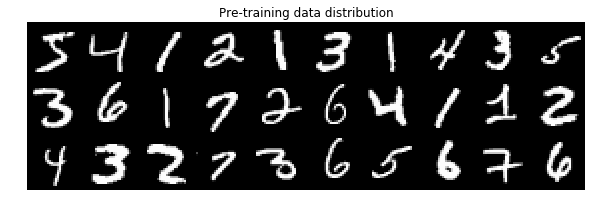

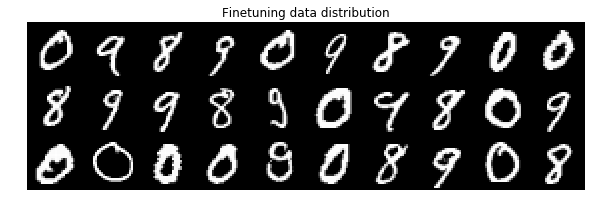

In [5]:
res = X_train.shape[1]
def make_grid(imgs, n_rows, n_cols):
    return imgs.reshape(n_rows, n_cols, res, res).swapaxes(1,2).reshape(n_rows * res, n_cols * res)
pretrain_grid = make_grid(X_train[:30], 3, 10)
transfer_grid = make_grid(X_transfer[:30], 3, 10)
def plot_grid(grid, title):
    plt.figure(figsize=(10, 30))
    imshow(grid, cmap='gray')
    plt.title(title)
    plt.axis('off')
plot_grid(pretrain_grid, "Pre-training data distribution")
plot_grid(transfer_grid, "Finetuning data distribution")


### Your TODOs: 
You are asked to pre-train a neural network on a split of the MNIST dataset and then fine-tune on the other split.  
Make sure to read every essential lines of code in the following training block, and complete the implementations in the TODO: block.

In [11]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
%matplotlib inline

def conv2d(input, output_shape, k=4, s=2, name='conv2d'):
    with tf.variable_scope(name):
        return slim.conv2d(input, output_shape, [k, k], stride=s)


def fc(input, output_shape, act_fn=tf.nn.relu, name='fc'):
    with tf.variable_scope(name):
        return slim.fully_connected(input, output_shape, activation_fn=act_fn)


def train(batch_size=100, num_epoch=3, learning_rate=1e-5,
          num_test=10000, datasets=None):

    sess = tf.InteractiveSession()
    
    # Build the model
    X = tf.placeholder(tf.float32, [None, 28, 28, 1])
    Y = tf.placeholder(tf.int64, [None])
    labels = tf.one_hot(Y, 10)
    _ = conv2d(X, 32, name='conv1')
    _ = conv2d(_, 64, name='conv2')
    _ = conv2d(_, 128, name='conv3')
    _ = conv2d(_, 256, name='conv4')
    _ = tf.reshape(_, [-1, np.prod(_.get_shape().as_list()[1:])])
    _ = fc(_, 256, name='fc1')
    logits = fc(_, 10, act_fn=None, name='fc2')

    loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
    loss_op = tf.reduce_mean(loss)

    global_step = tf.Variable(0, trainable=False)
    lr = tf.placeholder(tf.float32, shape=[])
    optimizer = tf.train.AdamOptimizer(lr)
    train_op = optimizer.minimize(loss, global_step=global_step)

    predict = tf.argmax(logits, 1)
    correct = tf.equal(predict, Y)
    accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))

    sess.run(tf.global_variables_initializer())

    # variables you will need
    total_loss = []
    total_accuracy = []
    total_loss_scratch = []
    total_accuracy_scratch = []
    
    # evaluation function
    def eval(data, labels):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(data.shape[0] // batch_size):
            X_ = data[i * batch_size:(i + 1) * batch_size][:]
            Y_ = labels[i * batch_size:(i + 1) * batch_size]
            accuracy = sess.run(accuracy_op, feed_dict = {X: X_, Y: Y_})
            eval_accuracy += accuracy
            eval_iter += 1
        return (eval_accuracy / eval_iter)
    
    # datasets
    X_train, Y_train = datasets['X_train'], datasets['Y_train']
    X_transfer, Y_transfer = datasets['X_transfer'], datasets['Y_transfer']
    X_test, Y_test = datasets['X_test'], datasets['Y_test']
    X_test_transfer, Y_test_transfer = datasets['X_test_transfer'], datasets['Y_test_transfer']
    num_train = len(X_train)
    num_transfer = len(X_transfer)
    print ('Number of training points: {}'.format(num_train))
    print ('Number of transferring points: {}'.format(num_transfer))
    
    # Train the model from scratch on MNIST 0 8 9
    print('\033[93mTraining from scratch on MNIST 0 8 9\033[0m')
    learning_rate = 1e-4
    for epoch in range(num_epoch):
        for i in range(num_transfer // batch_size):
            X_ = X_transfer[i * batch_size:(i + 1) * batch_size][:]
            Y_ = Y_transfer[i * batch_size:(i + 1) * batch_size]
            [_, loss, accuracy] = sess.run([train_op, loss_op, accuracy_op],
                                           feed_dict = {X: X_, Y: Y_, lr: learning_rate})
            total_loss_scratch.append(loss)
            total_accuracy_scratch.append(accuracy)
        print('[Epoch {}] loss: {}, accuracy: {}'.format(epoch, loss, accuracy))
    test_acc_wo_transfer = eval(X_test_transfer, Y_test_transfer)

    # re-intialize for experimenting our transfer learning
    sess.run(tf.global_variables_initializer())

    #############################################################################
    # TODO: Train the model on MNIST 1 2 3 4 5 6 7 from scratch                 #
    # and then fine-tune it on MNIST 0 8 9                                      #
    # Collect the training loss and the training accuracy                       #
    # fetched from each iteration                                               #
    # You should just store the training losses and accuracies during           #
    # fine-tuning in order to be compared with training from scratch            #
    #                                                                           #
    # After the two stages of the training (first pre-train and then            #
    # fine-tune), the length of total_loss and total_accuracy should be:        #
    # num_epoch * num_transfer / batch_size                                     #
    #############################################################################

    # Train the model on MNIST 1 2 3 4 5 6 7
    print('\033[93mPre-training on MNIST 1 2 3 4 5 6 7\033[0m')
    learning_rate = 1e-4
    for epoch in range(num_epoch):
        for i in range(num_train // batch_size):
            X_ = X_train[i * batch_size:(i + 1) * batch_size][:]
            Y_ = Y_train[i * batch_size:(i + 1) * batch_size]
            [_, loss, accuracy] = sess.run([train_op, loss_op, accuracy_op],
                                           feed_dict = {X: X_, Y: Y_, lr: learning_rate})
            #total_loss.append(loss)
            #total_accuracy.append(accuracy)
        print('[Epoch {}] loss: {}, accuracy: {}'.format(epoch, loss, accuracy))
    
    
    # Fine-tune the model on MNIST 0 8 9
    print('\033[93mFine-tuning on MNIST 0 8 9\033[0m')
    learning_rate = 1e-4
    for epoch in range(num_epoch):
        for i in range(num_transfer // batch_size):
            X_ = X_transfer[i * batch_size:(i + 1) * batch_size][:]
            Y_ = Y_transfer[i * batch_size:(i + 1) * batch_size]
            [_, loss, accuracy] = sess.run([train_op, loss_op, accuracy_op],
                                           feed_dict = {X: X_, Y: Y_, lr: learning_rate})
            total_loss.append(loss)
            total_accuracy.append(accuracy)
        print('[Epoch {}] loss: {}, accuracy: {}'.format(epoch, loss, accuracy))
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################   
    test_acc_w_transfer = eval(X_test_transfer, Y_test_transfer)

    return total_loss, total_accuracy,\
           total_loss_scratch, total_accuracy_scratch,\
           test_acc_w_transfer, test_acc_wo_transfer

In [12]:
tf.reset_default_graph()

loss, accuracy, loss_scratch, accuracy_scratch, test_acc_w_transfer,\
    test_acc_wo_transfer = train(datasets=datasets)

c:\users\ahmad\csci599-assignment1\env\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Number of training points: 42277
Number of transferring points: 200
Training from scratch on MNIST 0 8 9
[Epoch 0] loss: 1.8510595560073853, accuracy: 0.4300000071525574
[Epoch 1] loss: 0.9538525342941284, accuracy: 0.6399999856948853
[Epoch 2] loss: 0.28961342573165894, accuracy: 0.8799999952316284
Pre-training on MNIST 1 2 3 4 5 6 7
[Epoch 0] loss: 0.04772268235683441, accuracy: 0.9900000095367432
[Epoch 1] loss: 0.0035456595942378044, accuracy: 1.0
[Epoch 2] loss: 0.0019366689957678318, accuracy: 1.0
Fine-tuning on MNIST 0 8 9
[Epoch 0] loss: 6.164895534515381, accuracy: 0.03999999910593033
[Epoch 1] loss: 0.645230770111084, accuracy: 0.8100000023841858
[Epoch 2] loss: 0.1676657646894455, accuracy: 0.9100000262260437


### Check your results

Testing Accuracy w/o transfer learning: 0.8931034536197268
Testing Accuracy w/ transfer learning:  0.9327586211007217


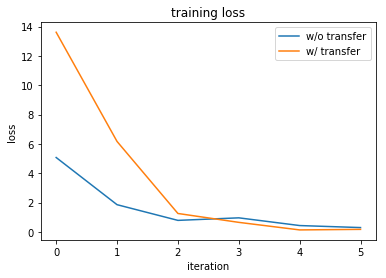

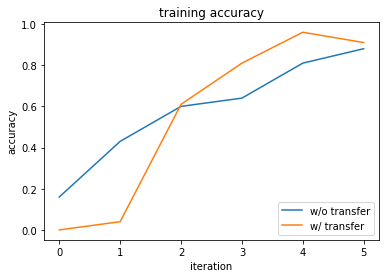

In [13]:
print ('\033[93mTesting Accuracy w/o transfer learning: {}\033[0m'.format(test_acc_wo_transfer))
print ('\033[93mTesting Accuracy w/ transfer learning:  {}\033[0m'.format(test_acc_w_transfer))

# Plot the training loss and the training accuracy
N = 50
plt.plot(loss_scratch[0:N], label='w/o transfer')
plt.plot(loss[0:N], label='w/ transfer')
plt.legend(loc='upper right')
plt.title('training loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()    

plt.plot(accuracy_scratch[0:N], label='w/o transfer')
plt.plot(accuracy[0:N], label='w/ transfer')
plt.legend(loc='lower right')
plt.title('training accuracy')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

### Inline Question: Describe what you observe from the above test set results and the plots
#### Ans: Clearly, the Testing Accuracy result is better when we do fine tuning. It is 93% with fine tuning whereas 89% without it. Also, by comparing the curves we can see the training accuracy is getteing better after training the model on MNIST 1 2 3 4 5 6 7. It is expected that fine tuning of a pretrained set will result in a better accuracy rather than training the same set from scratch